### requires python 3 and TSS conda environment (needed for parallelization)

### Motivation: 
TSS: Focused and dispersed. 
Within each TSS there are variations to where the start site occurs across different tissues. 
When calling our peaks, we choose the CHO peak if it occurs, otherwise pick the tissue with the maximum p-value.

One question that arises is when we call the TSS, how different are the read alignments when a) The TSS align b) The TSS are shifted between CHO and tissues and c) No CHO peak is seen, only tissues d) only CHO TSS

For each of these, how many TSS' are seen for each. How many tissues have a TSS when they all agree with CHO and when they are offset from CHO.

When they are offset versus aligned, what is the distribution of tags underneath (the density)


In the same vein, we want to make sure that the CHO GRO-Cap and CHO csRNA peaks are both showing similar buildup profiles, and that when plotting histograms, they don't just look good because the GRO-Cap is aligning on the GRO-cap peaks and csRNA aligning on csRNA peaks. Therefore, each should be done to the opposite calls.

In [1]:
## Parameters specific to where your folders are and your data
parameter_file = '../params/params.yaml'
import yaml
import sys

with open(parameter_file,'r') as f:
    doc = yaml.load(f)

#p = dic2obj(**doc)

data_folder = doc['data_folder']
tissues = doc['tissues'].split(',')
sys.path.append(doc['pipeline_path'])
ref_fa = doc['ref_fa']
anno_gff=doc['annotation']
mRNA_peak_file = doc["mRNA_peak_file"]

tss_annotation = doc['tss_annotation']


import os
from os.path import join
import sys
import pandas as pd
import matplotlib
import seaborn as sns
import pickle
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
from itertools import product
import glob
import re
from matplotlib_venn import venn2
from matplotlib import rcParams
import inspect
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
sys.setrecursionlimit(3000)
%load_ext autoreload
%autoreload 2
rcParams['figure.figsize'] = 8, 6
from tqdm import *
from os.path import basename
##mpl.use('Agg')
#mpl.style.use('ggplot')
#mpl.style.use('fivethirtyeight')
from Homer import *
import helper
import create_output
print('Number of tissues: ',len(tissues))

from collections import Counter


/home/isshamie/software/anaconda2/envs/TSS/lib/python3.7/site-packages/ipykernel_launcher.py:7: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  import sys


Number of tissues:  13


In [2]:
from numpanpar import parallel_df as pardf

## Parameters and directories

In [3]:
sample_peaks_dir = "../Results/tss_annotation_peaks/"
merged_dir = "../Results/merged"
save_dir = "Results/histograms/compare_tissues"
if not os.path.exists(save_dir):
    os.mkdir(save_dir)

### Load data

In [4]:
merged_df = pd.read_csv("../Results/merged/samples.merge",sep="\t", index_col=0)
merged_df.head()

/home/isshamie/software/anaconda2/envs/TSS/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3051: DtypeWarning: Columns (8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,Chr,Start,End,Strand,Stat,Parent files,Total subpeaks,f04_peaks/MiscOrgans_START1_and_MiscOrgans_startinput1,f04_peaks/Liver_START2_and_Liver_startinput1,f04_peaks/Brain_GROCap1_and_Brain_GRO1,...,f04_peaks/MiscOrgans_START2_and_MiscOrgans_startinput1,f04_peaks/Spleen_START1_and_Spleen_startinput1,f04_peaks/Lung_START2_and_Lung_startinput1,f04_peaks/CHO_START1_and_CHO_startinput1,f04_peaks/FemaleReproductive_START1_and_FemaleReproductive_startinput1,f04_peaks/Kidney_START2_and_Kidney_startinput1,f04_peaks/Kidney_GROCap1_and_Kidney_GRO1,f04_peaks/CHO_GROCap1_and_CHO_GRO1,f04_peaks/BMDMwt_GROCap1_and_BMDMwt_GRO1,f04_peaks/Spleen_START2_and_Spleen_startinput1
ID,,,,,,,,,,,,,,,,,,,,,
0,NW_020822452.1,16590187,16590584,+,16.227333,f04_peaks/MiscOrgans_START1_and_MiscOrgans_sta...,15,NW_020822452.1-1136,NaN,NW_020822452.1-1139,...,NaN,NaN,NaN,NW_020822452.1-450,NaN,NaN,NW_020822452.1-419,NW_020822452.1-145,NaN,NaN
1,NW_020822597.1,23595304,23595489,+,5.740000,f04_peaks/MiscOrgans_START1_and_MiscOrgans_sta...,16,NW_020822597.1-387,NaN,NW_020822597.1-324,...,NW_020822597.1-103,NW_020822597.1-248,NW_020822597.1-10,NaN,NW_020822597.1-101,NaN,NaN,NaN,NaN,NW_020822597.1-126
2,NW_020822680.1,728607,728829,+,7.579579,f04_peaks/MiscOrgans_START1_and_MiscOrgans_sta...,19,NW_020822680.1-92,NaN,NW_020822680.1-114,...,NaN,NaN,NaN,NW_020822680.1-37,NW_020822680.1-56,NaN,NW_020822680.1-67,NW_020822680.1-19,NW_020822680.1-44,NW_020822680.1-72
3,NW_020822602.1,10883074,10883337,+,3.992000,f04_peaks/MiscOrgans_START1_and_MiscOrgans_sta...,20,NW_020822602.1-204,NaN,NaN,...,NW_020822602.1-254,NW_020822602.1-122,NaN,NW_020822602.1-226,NaN,NaN,NaN,NW_020822602.1-303,NW_020822602.1-594,NW_020822602.1-266
4,NW_020822601.1,37427816,37427999,+,129.031738,f04_peaks/MiscOrgans_START1_and_MiscOrgans_sta...,23,NW_020822601.1-18,NaN,NW_020822601.1-1445,...,NW_020822601.1-52,NW_020822601.1-123,NaN,NW_020822601.1-41,NaN,NaN,NW_020822601.1-1949,NW_020822601.1-992,NW_020822601.1-2287,NW_020822601.1-12


In [5]:
meta_df = pd.read_csv("../Results/output/TSS1.exp.meta", sep="\t", index_col=0)
meta_df["ID"] = meta_df["ID"].fillna(-1).astype(int)
bed_df = read_bed_file("../Results/output/TSS1.exp.bed")
meta_df.head()


,Tissues,cs,CHO ATAC Region,ID,Gene,Gene ID,Transcript,Is Experimental
p1@Bmp4_XM_027386529.1,"Spleen,MiscOrgans,FemaleReproductive,Brain,Lun...",0b11,NaN,348823,Bmp4,NaN,XM_027386529.1,1.0
p2@Bmp4_XM_027386529.1,"Spleen,MiscOrgans,FemaleReproductive,Brain,Lun...",0b00,NaN,90264,Bmp4,NaN,XM_027386529.1,1.0
p3@Bmp4_XM_027386529.1,"Spleen,MiscOrgans,FemaleReproductive,Brain,Lun...",0b00,NaN,181215,Bmp4,NaN,XM_027386529.1,1.0
p1@Bmp4_XM_027386528.1,"Heart,Spleen,MiscOrgans,FemaleReproductive,Bra...",0b11,NaN,308710,Bmp4,NaN,XM_027386528.1,1.0
p1@Cdkn3_XM_027386531.1,"BMDMwt,Spleen,MiscOrgans,FemaleReproductive,CH...",0b11,NaN,237253,Cdkn3,NaN,XM_027386531.1,1.0


## Construct peak-by-location data

In [6]:
sample_files = glob.glob(os.path.join(sample_peaks_dir, "sample_*"))
columns = list(map(lambda x: x.split("sample_")[1].split(".tsv")[0],sample_files))
files_dict = {c:sample_files[ind] for ind, c in enumerate(columns)}
peak_by_location = pd.DataFrame(index=meta_df["ID"],columns=columns)
peak_by_location.head()

,Kidney_START2_and_Kidney_startinput1,Lung_START2_and_Lung_startinput1,Liver_START2_and_Liver_startinput1,Brain_START1_and_Brain_startinput2,Spleen_START2_and_Spleen_startinput1,Liver_START1_and_Liver_startinput1,Brain_START3_and_Brain_startinput2,BMDM1hKLA_GROCap1_and_BMDM1hKLA_GRO1,Lung_START1_and_Lung_startinput1,CHO_GROCap2_and_CHO_GRO2,...,Heart_START1_and_Heart_startinput1,MiscOrgans_START1_and_MiscOrgans_startinput1,Brain_START2_and_Brain_startinput1,CHO_GROCap2_and_CHO_GRO1,Pancreas_START1_and_Pancreas_startinput1,CHO_START1_and_CHO_startinput1,Liver_GROCap1_and_Liver_GRO1,CHO_GROCap1_and_CHO_GRO2,Heart_START2_and_Heart_startinput1,Pancreas_START2_and_Pancreas_startinput1
ID,,,,,,,,,,,,,,,,,,,,,
348823,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
90264,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
181215,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
308710,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
237253,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### To start, use all samples in columns (can average over tissues later)

A. Create a dictionary where each sample is a key and their dataframe of peaks is the value  
B. Loop through the meta_df IDs.   
    For each ID:  
    Determine which samples had the ID (use merged to determine where there is no null)  
    Loop through each sample that had the peak:  
        Get the peak from their sample_{sample} file, and get their location and fill it in. 
    

### Create sample dictionary

In [7]:
sample_dict = dict()
for ind, f in enumerate(sample_files):
    print(f)
    print(columns[ind])
    name = columns[ind]
    sample_dict[name] = pd.read_csv(f, sep="\t")

../Results/tss_annotation_peaks/sample_Kidney_START2_and_Kidney_startinput1.tsv
Kidney_START2_and_Kidney_startinput1
../Results/tss_annotation_peaks/sample_Lung_START2_and_Lung_startinput1.tsv
Lung_START2_and_Lung_startinput1
../Results/tss_annotation_peaks/sample_Liver_START2_and_Liver_startinput1.tsv
Liver_START2_and_Liver_startinput1
../Results/tss_annotation_peaks/sample_Brain_START1_and_Brain_startinput2.tsv
Brain_START1_and_Brain_startinput2
../Results/tss_annotation_peaks/sample_Spleen_START2_and_Spleen_startinput1.tsv
Spleen_START2_and_Spleen_startinput1
../Results/tss_annotation_peaks/sample_Liver_START1_and_Liver_startinput1.tsv
Liver_START1_and_Liver_startinput1
../Results/tss_annotation_peaks/sample_Brain_START3_and_Brain_startinput2.tsv
Brain_START3_and_Brain_startinput2
../Results/tss_annotation_peaks/sample_BMDM1hKLA_GROCap1_and_BMDM1hKLA_GRO1.tsv
BMDM1hKLA_GROCap1_and_BMDM1hKLA_GRO1
../Results/tss_annotation_peaks/sample_Lung_START1_and_Lung_startinput1.tsv
Lung_START1_

In [8]:
def par_peak_by_location(df, files_dict):
    # Dataframe will be tissue-by-peak instead of peak-by-sample to make the parallelization work
    for name in df.index.values:
        #name = columns[ind]
        f = files_dict[name]
        curr_sample = pd.read_csv(f, sep="\t", index_col=0)
        curr_merge = pd.read_csv(f.replace("sample","merged"), sep="\t", index_col=0)
        curr_merge = curr_merge.loc[:,curr_merge.columns.str.contains("f04_peaks/")]
        curr_merge.columns = list(map(lambda x: x.split("f04_peaks/")[1], curr_merge.columns.values))
        # Remove the comma, indicating multiple peaks, which doesnt happen often
        curr_merge = curr_merge.loc[~(curr_merge[name].str.contains(",")), name] #Take only the column of the sample

        for ind2, val in tqdm(curr_merge.iteritems()):
            df.loc[name,ind2] = np.floor((curr_sample.loc[val, "Start"] + curr_sample.loc[val, "End"])/2)
            
    return df

In [9]:
peak_by_location = pardf(peak_by_location.transpose(), par_peak_by_location, func_args=(files_dict,), num_processes=24).transpose()
peak_by_location = peak_by_location.sort_index()

5368it [00:19, 277.64it/s]
4198it [00:20, 167.58it/s]
4991it [00:22, 213.71it/s]
9385it [00:28, 329.78it/s]
5570it [00:28, 177.25it/s]
3448it [00:13, 239.46it/s]
6865it [00:35, 175.83it/s]
8239it [00:43, 179.44it/s]
8582it [00:45, 238.93it/s]
9184it [00:48, 191.33it/s]
1259it [00:04, 222.60it/s]
9257it [00:49, 201.92it/s]
7945it [00:23, 340.08it/s]
9915it [00:33, 302.49it/s]]
9320it [00:55, 96.02it/s]s]
10648it [00:36, 294.98it/s]
9878it [00:33, 139.42it/s]]
9699it [00:58, 90.22it/s]s]
10054it [01:01, 78.99it/s]]
10220it [01:04, 88.91it/s]]
9130it [00:44, 204.00it/s]]
11474it [00:45, 136.98it/s]
11479it [00:45, 254.35it/s]
5040it [00:20, 251.58it/s]]
10881it [00:40, 266.19it/s]
11207it [01:10, 159.99it/s]
10999it [01:11, 153.45it/s]
6424it [00:28, 136.47it/s]]
6542it [00:29, 137.91it/s]]
11876it [01:13, 161.32it/s]
10473it [00:37, 277.65it/s]
7449it [00:35, 208.03it/s]
8487it [00:34, 247.20it/s]
8479it [00:31, 265.48it/s]
8517it [00:31, 268.81it/s]


In [10]:
peak_by_location.to_csv(os.path.join(save_dir,"peak_by_location.tsv"), sep="\t")

In [11]:
# for ind, f in enumerate(sample_files):
#     print(f)
#     print(columns[ind])
#     name = columns[ind]
#     curr_sample = pd.read_csv(f, sep="\t", index_col=0)
#     curr_merge = pd.read_csv(f.replace("sample","merged"), sep="\t", index_col=0)
#     curr_merge = curr_merge.loc[:,curr_merge.columns.str.contains("f04_peaks/")]
#     curr_merge.columns = list(map(lambda x: x.split("f04_peaks/")[1], curr_merge.columns.values))
#     curr_merge = curr_merge.loc[~(curr_merge[name].str.contains(",")), name] #Take only the column of the sample

#     for ind2, val in tqdm(curr_merge.iteritems()):
#         peak_by_location.loc[ind2, name] = (curr_sample.loc[val, "Start"] + curr_sample.loc[val, "End"])/2


## Merge the samples together into tissues

In [12]:
tissue_peaks_by_location = pd.DataFrame(index=peak_by_location.index, columns=tissues)
for t in tissues:
    tissue_peaks_by_location[t] = peak_by_location.loc[:,peak_by_location.columns.str.contains(t)].mean(axis=1, 
                                                                                                       skipna=True).apply(np.floor)
tissue_peaks_by_location.to_csv(os.path.join(save_dir,"tissue_peak_by_location.tsv"), sep="\t")

### Get peaks in CHO and not in CHO

In [13]:
tissue = "CHO"
peaks_in_cho = set(tissue_peaks_by_location.loc[~(tissue_peaks_by_location[tissue].isnull())].index)
print(len(peaks_in_cho))

peaks_not_in_cho = set(tissue_peaks_by_location[~tissue_peaks_by_location.isnull().all(axis=1)].drop(peaks_in_cho).index)
print(len(peaks_not_in_cho))
print(peaks_in_cho)
print(peaks_not_in_cho)

12278
12514
{4, 6, 8, 131086, 16, 21, 131093, 131094, 131095, 426005, 131108, 491557, 131110, 491564, 488476, 52, 62, 65, 299608, 76, 77, 299609, 89, 90, 91, 93, 94, 488487, 488488, 111, 118, 131191, 131192, 488492, 128, 491648, 295049, 140, 131212, 295052, 146, 150, 295064, 488499, 175, 179, 186, 187, 188, 191, 488505, 195, 198, 295111, 200, 201, 202, 203, 204, 426182, 491727, 208, 488509, 426204, 224, 225, 226, 227, 488512, 235, 295152, 244, 246, 247, 248, 249, 491769, 251, 258, 426274, 293, 294, 296, 295209, 298, 426290, 426297, 426312, 330, 426314, 426321, 491858, 346, 347, 348, 349, 350, 351, 488539, 295275, 365, 375, 488542, 426365, 426366, 426368, 426374, 404, 408, 409, 426392, 426401, 488551, 426413, 164275, 164276, 426421, 295350, 164287, 426437, 164294, 491975, 426459, 164319, 164320, 164321, 426483, 426484, 492022, 488570, 426503, 426504, 164366, 488577, 492079, 164410, 492090, 164414, 488581, 164417, 164418, 164419, 164421, 164422, 164423, 492102, 164434, 164435, 164450, 16

### Determine peaks that are in or not in agreement

In [14]:
def agree_peaks(tissue_peaks_by_location,tol=0, tissue='CHO'):    
    # Get the peaks in CHO first
    peaks_in_cho = set(tissue_peaks_by_location.loc[~(tissue_peaks_by_location[tissue].isnull())].index)
    # For all these CHO peaks, see which ones are i) unique, ii) seen in >n tissues and are the same. seen in >n tissues and are different
    no_cho_tissue_peaks_by_location = tissue_peaks_by_location.drop(tissue, axis=1)

    peaks_cho_agree = dict()
    peaks_cho_disagree = dict()

    for p in tqdm(peaks_in_cho):
        loc = tissue_peaks_by_location.loc[p, tissue]
        agree = (np.abs(no_cho_tissue_peaks_by_location.loc[p].dropna() - loc) <= tol ).sum()
        disagree = (np.abs(no_cho_tissue_peaks_by_location.loc[p].dropna() - loc) > tol ).sum()

        
        peaks_cho_agree[p] = agree
        peaks_cho_disagree[p] = disagree

    return peaks_cho_agree, peaks_cho_disagree

In [15]:
def retrieve_peaks(locations_df, meta_df, peaks_cho_agree, peaks_cho_disagree, n_ag, n_dis,n_tot):
    """Will extract peaks that have a certain qualification in terms of where the start signs align.
    Parameters:
    -----------
    locations_df: peak-by-sample df where each element is the peak location (assumes the same chromosome), or null if no peak detected there.
    """
    peaks_to_keep = set()
    for p in peaks_cho_agree:
        tot = peaks_cho_agree[p] + peaks_cho_disagree[p]
        if tot <= n_tot: 
            peaks_to_keep.add(p)
        elif peaks_cho_agree[p] >= n_ag and peaks_cho_disagree[p] >= n_dis:
            peaks_to_keep.add(p)
    return meta_df[meta_df["ID"].isin(peaks_to_keep)]

# With a tolerance of 0

100%|██████████| 12278/12278 [00:53<00:00, 231.34it/s]


Text(0.5, 1.0, 'Fraction of tissues that have a peak that agree tol=0')

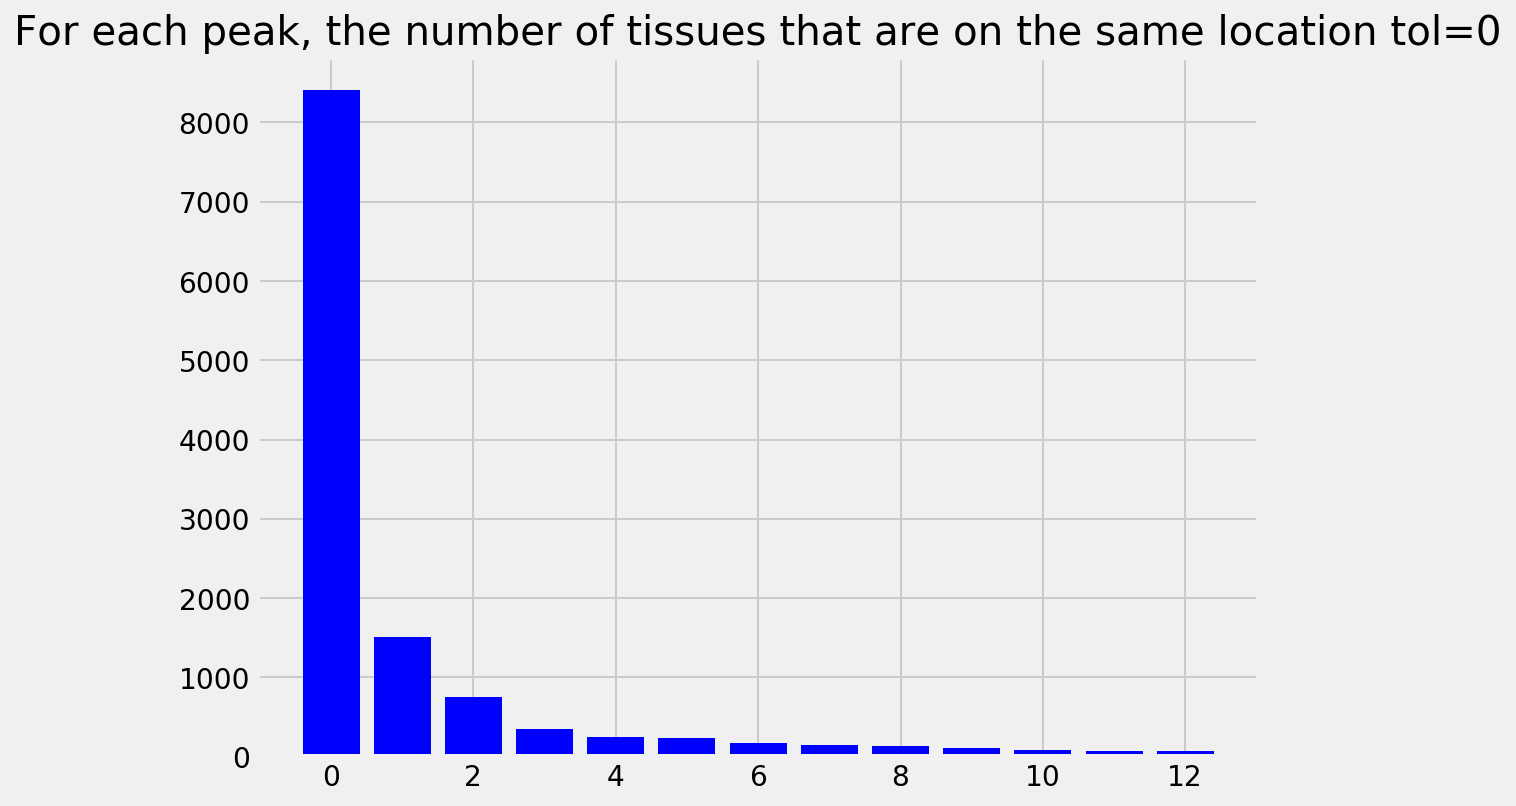

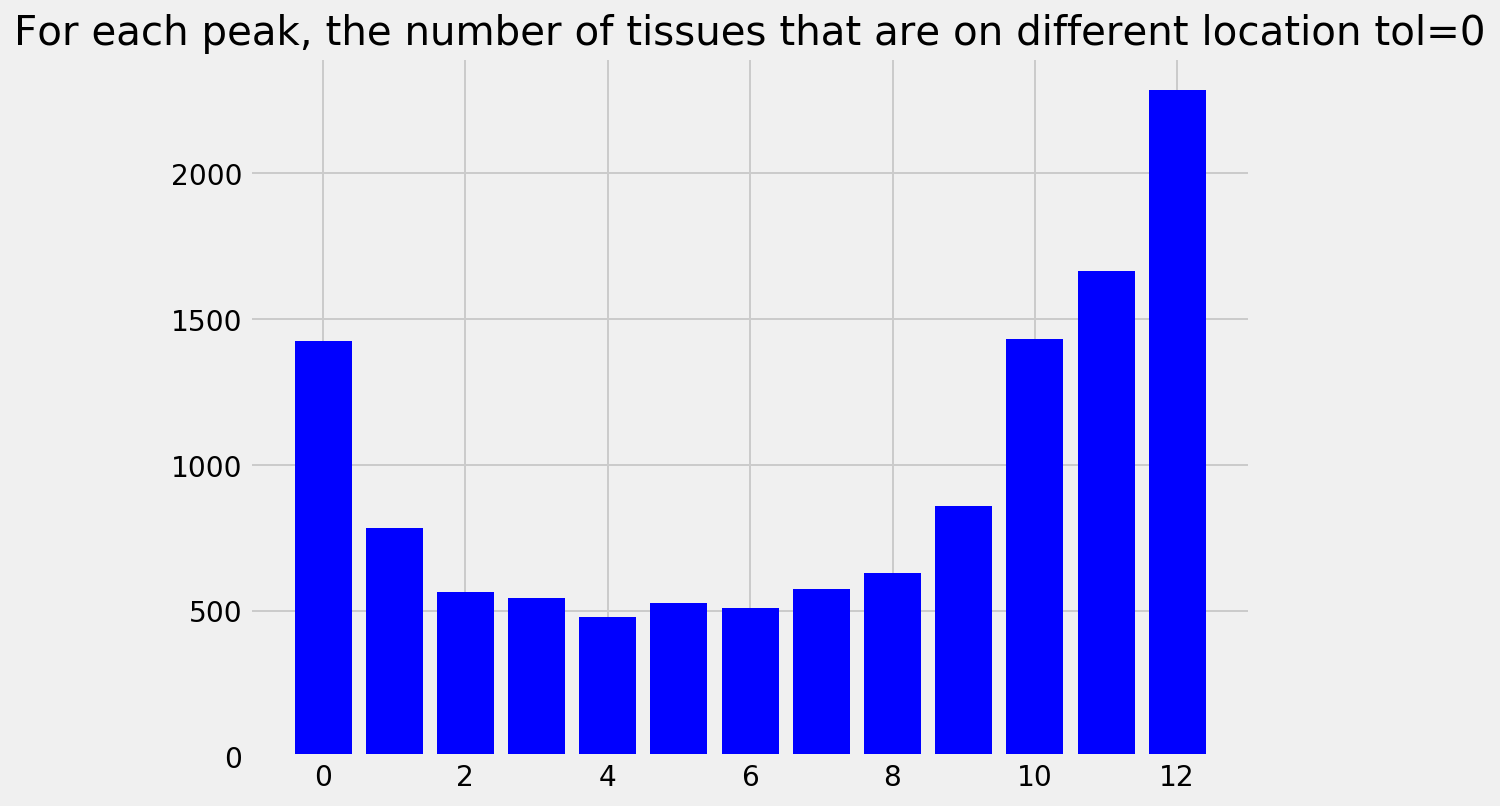

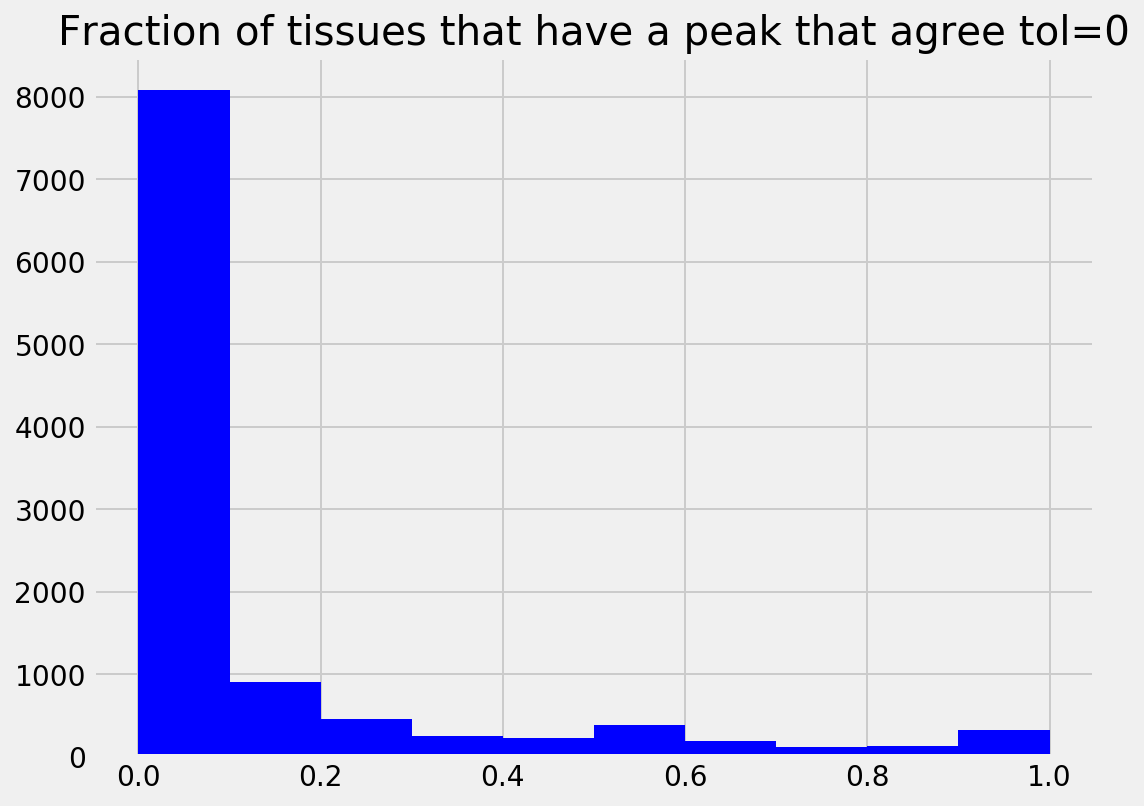

In [16]:
peaks_cho_agree, peaks_cho_disagree = agree_peaks(tissue_peaks_by_location,tol=0, tissue='CHO')

f = plt.figure()
labels, values = zip(*Counter(peaks_cho_agree.values()).items())
plt.bar(labels, values)
plt.title("For each peak, the number of tissues that are on the same location tol=0")
#pd.Series(Counter(peaks_cho_agree)).plot.bar(color='y')


f = plt.figure()
labels, values = zip(*Counter(peaks_cho_disagree.values()).items())
plt.bar(labels, values)
plt.title("For each peak, the number of tissues that are on different location tol=0")


fraction_agree = []
for p in peaks_cho_agree:
    num_tot = peaks_cho_agree[p]+peaks_cho_disagree[p]
    if not num_tot == 0:
        fraction_agree.append(peaks_cho_agree[p]/(peaks_cho_agree[p]+peaks_cho_disagree[p]))

f = plt.figure()
plt.hist(fraction_agree)
plt.title("Fraction of tissues that have a peak that agree tol=0")

### A. TSS only in CHO

In [17]:
# Only CHO has peak:
#peaks_cho_agree, peaks_cho_disagree = agree_peaks(tissue_peaks_by_location,tol=0, tissue='CHO')
#

In [18]:
only_in_cho = retrieve_peaks(tissue_peaks_by_location, meta_df, peaks_cho_agree, peaks_cho_disagree, n_ag=20, n_dis=20,n_tot=0)
only_in_cho

,Tissues,cs,CHO ATAC Region,ID,Gene,Gene ID,Transcript,Is Experimental
p2@Dlgap5_XM_027386546.1,"BMDMwt,Brain,MiscOrgans,Spleen,CHO,BMDM1hKLA,F...",0b10,NaN,108479,Dlgap5,NaN,XM_027386546.1,1.0
p1@LOC100768260_XM_027386564.1,CHO,0b00,NaN,344845,LOC100768260,NaN,XM_027386564.1,1.0
p2@Chd8_XM_027386661.1,"Heart,Spleen,MiscOrgans,FemaleReproductive,CHO...",0b00,NaN,352245,Chd8,NaN,XM_027386661.1,1.0
p1@Il1rl1_XM_027386751.1,CHO,0b10,NaN,490977,Il1rl1,NaN,XM_027386751.1,1.0
p2@Map4k4_XM_027386764.1,"Heart,Spleen,MiscOrgans,FemaleReproductive,CHO...",0b10,NaN,104084,Map4k4,NaN,XM_027386764.1,1.0
...,...,...,...,...,...,...,...,...
p2@LOC113838138_XM_027433907.1,"BMDMwt,Spleen,FemaleReproductive,CHO,Brain,Lun...",0b00,NaN,102866,LOC113838138,NaN,XM_027433907.1,1.0
p1@LOC107977324_XM_027434064.1,CHO,0b10,NaN,103618,LOC107977324,NaN,XM_027434064.1,1.0
p2@LOC107977324_XM_027434064.1,CHO,0b00,NaN,419522,LOC107977324,NaN,XM_027434064.1,1.0
p1@LOC100757478_XM_027434222.1,CHO,0b00,NaN,288708,LOC100757478,NaN,XM_027434222.1,1.0


### B. TSS offset  CHO and other tissues

In [19]:
cho_dis3 = retrieve_peaks(tissue_peaks_by_location, meta_df, peaks_cho_agree, peaks_cho_disagree, n_ag=0, n_dis=3,n_tot=-1)
cho_dis3

,Tissues,cs,CHO ATAC Region,ID,Gene,Gene ID,Transcript,Is Experimental
p1@Cdkn3_XM_027386531.1,"BMDMwt,Spleen,MiscOrgans,FemaleReproductive,CH...",0b11,NaN,237253,Cdkn3,NaN,XM_027386531.1,1.0
p1@Cnih1_XM_027386534.1,"Heart,BMDMwt,Spleen,MiscOrgans,FemaleReproduct...",0b11,NaN,298307,Cnih1,NaN,XM_027386534.1,1.0
p1@Cgrrf1_XM_027386536.1,"Heart,Spleen,MiscOrgans,FemaleReproductive,CHO...",0b11,NaN,348288,Cgrrf1,NaN,XM_027386536.1,1.0
p1@Samd4a_XM_027386537.1,"Heart,Spleen,MiscOrgans,FemaleReproductive,Bra...",0b11,NaN,342596,Samd4a,NaN,XM_027386537.1,1.0
p1@Gch1_XM_027386540.1,"Heart,BMDMwt,Spleen,MiscOrgans,FemaleReproduct...",0b11,NaN,243948,Gch1,NaN,XM_027386540.1,1.0
...,...,...,...,...,...,...,...,...
p1@LOC113838538_XM_027434165.1,"MiscOrgans,CHO,Brain,Lung,Muscle,Kidney",0b00,NaN,22579,LOC113838538,NaN,XM_027434165.1,1.0
p1@LOC113838537_XM_027434161.1,"Heart,Spleen,FemaleReproductive,CHO,Brain,Lung...",0b11,NaN,508225,LOC113838537,NaN,XM_027434161.1,1.0
p1@LOC113839076_XM_027434536.1,"Heart,BMDMwt,MiscOrgans,Spleen,FemaleReproduct...",0b11,NaN,23577,LOC113839076,NaN,XM_027434536.1,1.0
p1@LOC113839111_XM_027434561.1,"Heart,Spleen,MiscOrgans,FemaleReproductive,CHO...",0b11,NaN,127972,LOC113839111,NaN,XM_027434561.1,1.0


### C. TSS agree CHO and tissues

In [20]:
cho_ag3 = retrieve_peaks(tissue_peaks_by_location, meta_df, peaks_cho_agree, peaks_cho_disagree, n_ag=3, n_dis=0,n_tot=-1)
cho_ag3

,Tissues,cs,CHO ATAC Region,ID,Gene,Gene ID,Transcript,Is Experimental
p1@Cgrrf1_XM_027386536.1,"Heart,Spleen,MiscOrgans,FemaleReproductive,CHO...",0b11,NaN,348288,Cgrrf1,NaN,XM_027386536.1,1.0
p1@Samd4a_XM_027386537.1,"Heart,Spleen,MiscOrgans,FemaleReproductive,Bra...",0b11,NaN,342596,Samd4a,NaN,XM_027386537.1,1.0
p1@Lgals3_XM_027386548.1,"Heart,BMDMwt,Spleen,MiscOrgans,FemaleReproduct...",0b11,NaN,237676,Lgals3,NaN,XM_027386548.1,1.0
p1@Ktn1_XM_027386554.1,"Heart,Spleen,MiscOrgans,FemaleReproductive,CHO...",0b11,NaN,190199,Ktn1,NaN,XM_027386554.1,1.0
p1@Ap5m1_XM_027386573.1,"Heart,Spleen,MiscOrgans,FemaleReproductive,CHO...",0b11,NaN,452191,Ap5m1,NaN,XM_027386573.1,1.0
...,...,...,...,...,...,...,...,...
p1@Tsc22d3_XM_027433605.1,"BMDMwt,Spleen,MiscOrgans,FemaleReproductive,CH...",0b11,NaN,354531,Tsc22d3,NaN,XM_027433605.1,1.0
p1@Tsc22d3_XM_027433606.1,"Heart,Spleen,MiscOrgans,FemaleReproductive,CHO...",0b11,NaN,160868,Tsc22d3,NaN,XM_027433606.1,1.0
p1@Morc4_XM_027433665.1,"Heart,Brain,MiscOrgans,Spleen,CHO,BMDM1hKLA,Fe...",0b11,NaN,131005,Morc4,NaN,XM_027433665.1,1.0
p1@LOC100752799_XM_027433927.1,"Heart,Spleen,MiscOrgans,FemaleReproductive,CHO...",0b11,NaN,355264,LOC100752799,NaN,XM_027433927.1,1.0


### D. TSS offset from CHO, but take the tissue instead of CHO (using max or next max)

In [21]:
cho_dis3_maxDist_bed = bed_df.loc[cho_dis3.index]

for p in tqdm(cho_dis3["ID"].values):
    cho = tissue_peaks_by_location.loc[p, tissue]
    new_start = int(tissue_peaks_by_location.loc[p,(np.abs(cho - tissue_peaks_by_location.loc[p])).idxmax()])
    if new_start != 0:
        tss_index = meta_df[meta_df["ID"] == p].index[0]
        cho_dis3_maxDist_bed.loc[tss_index, "Start"] = new_start-76
        cho_dis3_maxDist_bed.loc[tss_index, "End"] = new_start+75



100%|██████████| 9505/9505 [01:00<00:00, 156.92it/s]


#### Save results as bed files

In [22]:
write_bed_file(cho_dis3_maxDist_bed, os.path.join(save_dir,"cho_disagree3_maxDistance_tol_0.tsv" ))
write_bed_file(bed_df.loc[cho_ag3.index], os.path.join(save_dir, "cho_agree3_tol_0.tsv"))
write_bed_file(bed_df.loc[cho_dis3.index], os.path.join(save_dir, "cho_disagree3_tol_0.tsv"))
write_bed_file(bed_df.loc[only_in_cho.index], os.path.join(save_dir, "cho_only_tol_0.tsv"))
write_bed_file(bed_df.loc[meta_df[meta_df["ID"].isin(peaks_not_in_cho)].index], os.path.join(save_dir, "not_in_cho.tsv"))

### E. TSS different across CHO samples

# With a tolerance of 10

100%|██████████| 12278/12278 [00:52<00:00, 235.87it/s]


Text(0.5, 1.0, 'Fraction of tissues that have a peak that agree tol=10')

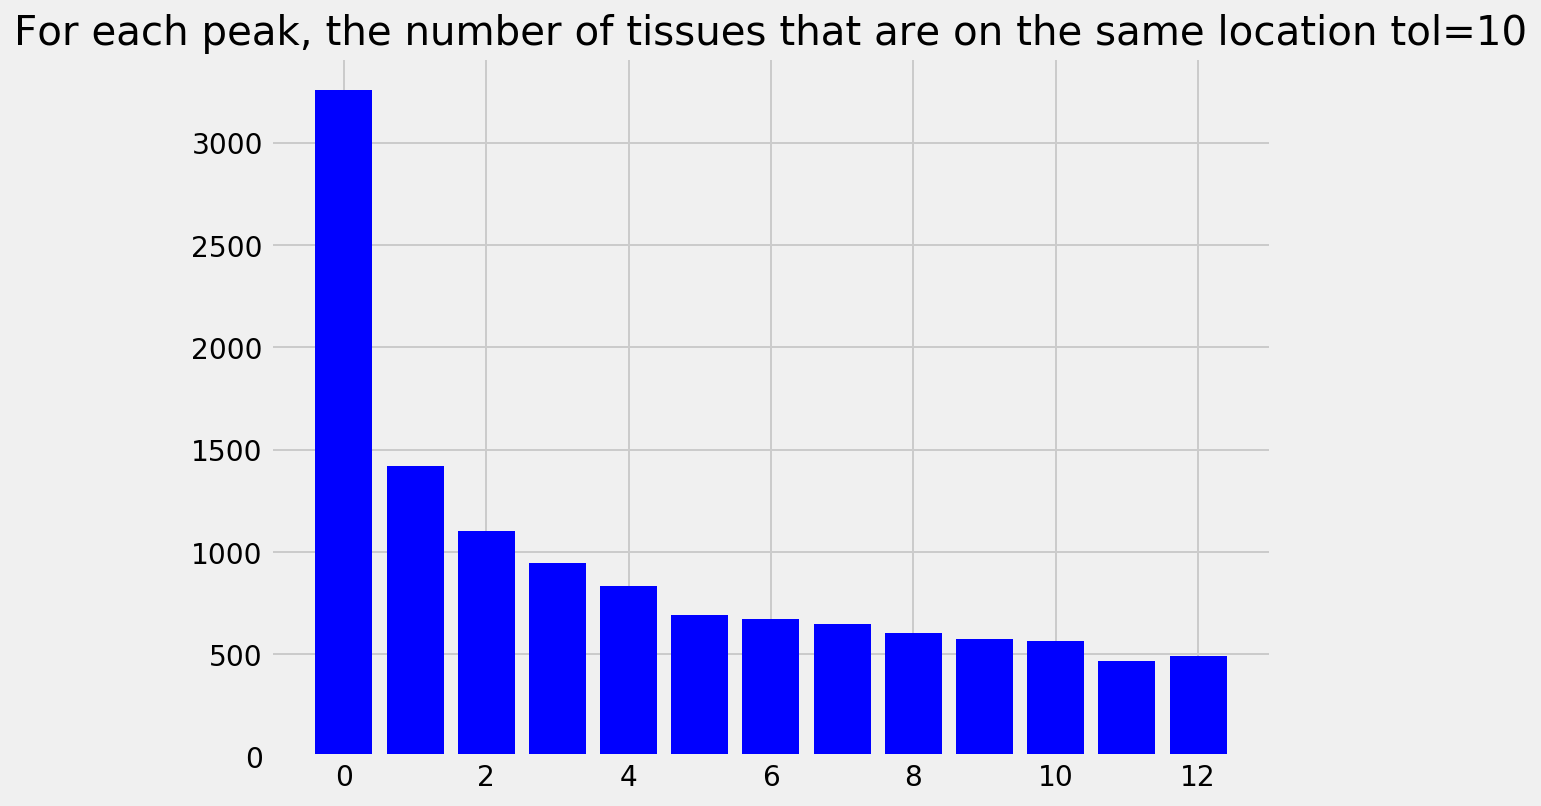

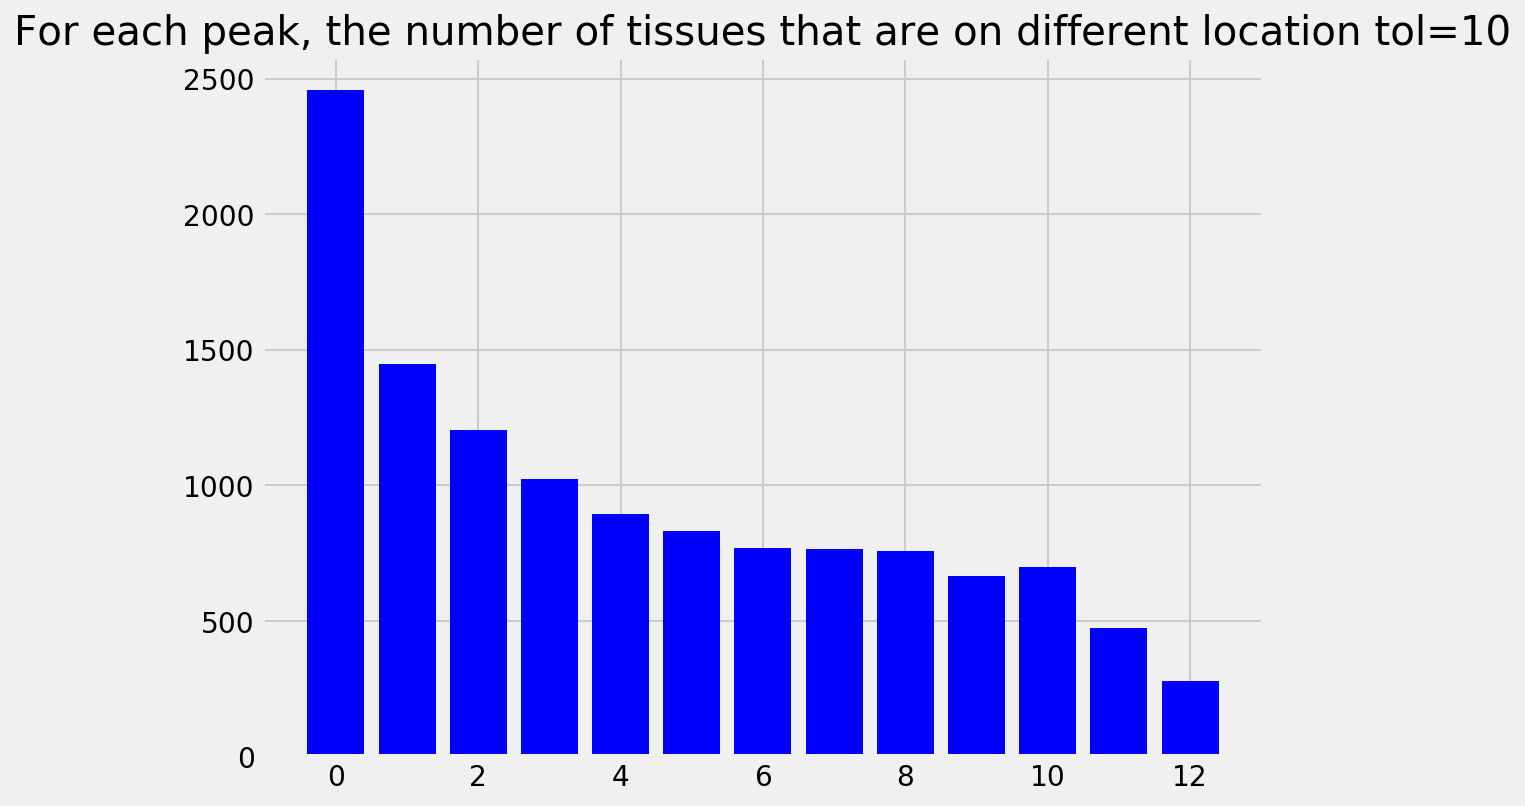

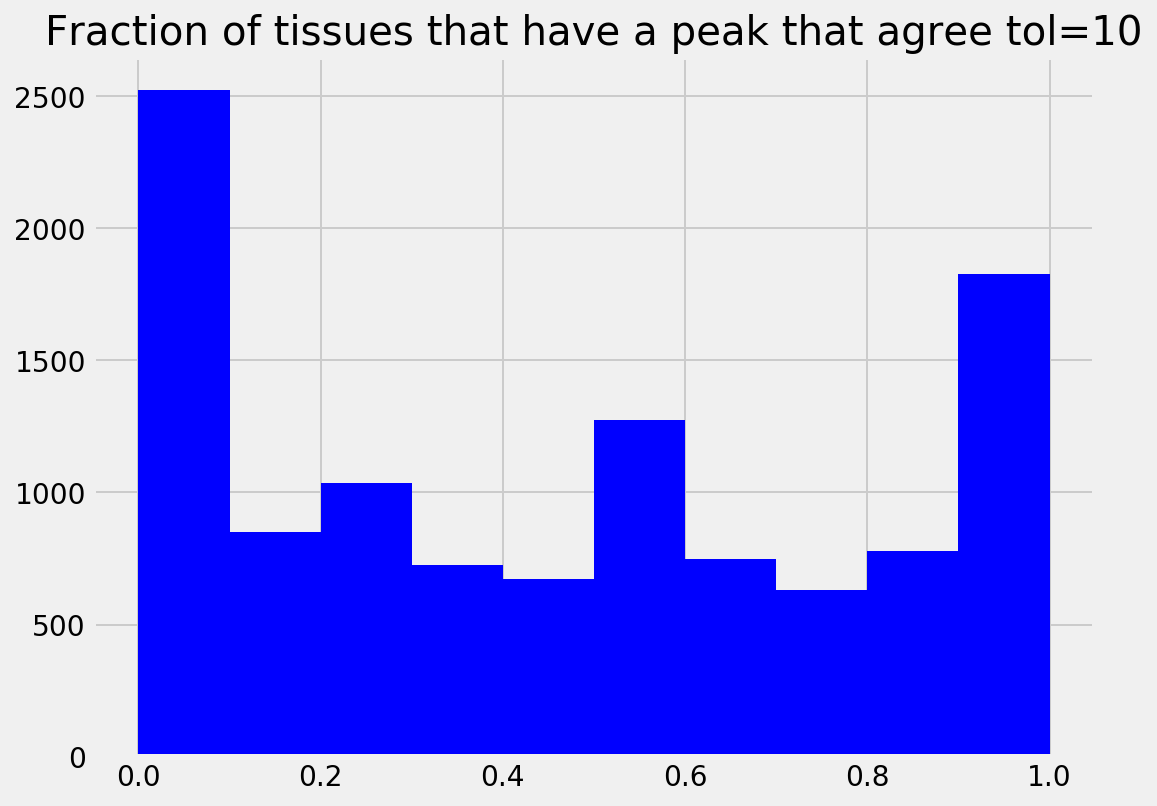

In [23]:
peaks_cho_agree, peaks_cho_disagree = agree_peaks(tissue_peaks_by_location,tol=10, tissue='CHO')
f = plt.figure()
labels, values = zip(*Counter(peaks_cho_agree.values()).items())
plt.bar(labels, values)
plt.title("For each peak, the number of tissues that are on the same location tol=10")
#pd.Series(Counter(peaks_cho_agree)).plot.bar(color='y')


f = plt.figure()
labels, values = zip(*Counter(peaks_cho_disagree.values()).items())
plt.bar(labels, values)
plt.title("For each peak, the number of tissues that are on different location tol=10")


fraction_agree = []
for p in peaks_cho_agree:
    num_tot = peaks_cho_agree[p]+peaks_cho_disagree[p]
    if not num_tot == 0:
        fraction_agree.append(peaks_cho_agree[p]/(peaks_cho_agree[p]+peaks_cho_disagree[p]))

f = plt.figure()
plt.hist(fraction_agree)
plt.title("Fraction of tissues that have a peak that agree tol=10")

### A. TSS only in CHO

In [24]:
only_in_cho = retrieve_peaks(tissue_peaks_by_location, meta_df, peaks_cho_agree, peaks_cho_disagree, n_ag=20, n_dis=20,n_tot=0)
only_in_cho

,Tissues,cs,CHO ATAC Region,ID,Gene,Gene ID,Transcript,Is Experimental
p2@Dlgap5_XM_027386546.1,"BMDMwt,Brain,MiscOrgans,Spleen,CHO,BMDM1hKLA,F...",0b10,NaN,108479,Dlgap5,NaN,XM_027386546.1,1.0
p1@LOC100768260_XM_027386564.1,CHO,0b00,NaN,344845,LOC100768260,NaN,XM_027386564.1,1.0
p2@Chd8_XM_027386661.1,"Heart,Spleen,MiscOrgans,FemaleReproductive,CHO...",0b00,NaN,352245,Chd8,NaN,XM_027386661.1,1.0
p1@Il1rl1_XM_027386751.1,CHO,0b10,NaN,490977,Il1rl1,NaN,XM_027386751.1,1.0
p2@Map4k4_XM_027386764.1,"Heart,Spleen,MiscOrgans,FemaleReproductive,CHO...",0b10,NaN,104084,Map4k4,NaN,XM_027386764.1,1.0
...,...,...,...,...,...,...,...,...
p2@LOC113838138_XM_027433907.1,"BMDMwt,Spleen,FemaleReproductive,CHO,Brain,Lun...",0b00,NaN,102866,LOC113838138,NaN,XM_027433907.1,1.0
p1@LOC107977324_XM_027434064.1,CHO,0b10,NaN,103618,LOC107977324,NaN,XM_027434064.1,1.0
p2@LOC107977324_XM_027434064.1,CHO,0b00,NaN,419522,LOC107977324,NaN,XM_027434064.1,1.0
p1@LOC100757478_XM_027434222.1,CHO,0b00,NaN,288708,LOC100757478,NaN,XM_027434222.1,1.0


### B. TSS offset  CHO and other tissues

In [25]:
cho_dis3 = retrieve_peaks(tissue_peaks_by_location, meta_df, peaks_cho_agree, peaks_cho_disagree, n_ag=0, n_dis=3,n_tot=-1)
cho_dis3

,Tissues,cs,CHO ATAC Region,ID,Gene,Gene ID,Transcript,Is Experimental
p1@Cdkn3_XM_027386531.1,"BMDMwt,Spleen,MiscOrgans,FemaleReproductive,CH...",0b11,NaN,237253,Cdkn3,NaN,XM_027386531.1,1.0
p1@Cnih1_XM_027386534.1,"Heart,BMDMwt,Spleen,MiscOrgans,FemaleReproduct...",0b11,NaN,298307,Cnih1,NaN,XM_027386534.1,1.0
p1@Cgrrf1_XM_027386536.1,"Heart,Spleen,MiscOrgans,FemaleReproductive,CHO...",0b11,NaN,348288,Cgrrf1,NaN,XM_027386536.1,1.0
p1@Wdhd1_XM_027386542.1,"BMDMwt,Spleen,MiscOrgans,FemaleReproductive,CH...",0b11,NaN,508092,Wdhd1,NaN,XM_027386542.1,1.0
p1@Socs4_XM_027386543.1,"Heart,Spleen,MiscOrgans,FemaleReproductive,CHO...",0b11,NaN,160861,Socs4,NaN,XM_027386543.1,1.0
...,...,...,...,...,...,...,...,...
p1@LOC113838538_XM_027434165.1,"MiscOrgans,CHO,Brain,Lung,Muscle,Kidney",0b00,NaN,22579,LOC113838538,NaN,XM_027434165.1,1.0
p1@LOC113838537_XM_027434161.1,"Heart,Spleen,FemaleReproductive,CHO,Brain,Lung...",0b11,NaN,508225,LOC113838537,NaN,XM_027434161.1,1.0
p1@LOC113839076_XM_027434536.1,"Heart,BMDMwt,MiscOrgans,Spleen,FemaleReproduct...",0b11,NaN,23577,LOC113839076,NaN,XM_027434536.1,1.0
p1@LOC113839111_XM_027434561.1,"Heart,Spleen,MiscOrgans,FemaleReproductive,CHO...",0b11,NaN,127972,LOC113839111,NaN,XM_027434561.1,1.0


### C. TSS agree CHO and tissues

In [26]:
cho_ag3 = retrieve_peaks(tissue_peaks_by_location, meta_df, peaks_cho_agree, peaks_cho_disagree, n_ag=3, n_dis=0,n_tot=-1)
cho_ag3

,Tissues,cs,CHO ATAC Region,ID,Gene,Gene ID,Transcript,Is Experimental
p1@Cnih1_XM_027386534.1,"Heart,BMDMwt,Spleen,MiscOrgans,FemaleReproduct...",0b11,NaN,298307,Cnih1,NaN,XM_027386534.1,1.0
p1@Cgrrf1_XM_027386536.1,"Heart,Spleen,MiscOrgans,FemaleReproductive,CHO...",0b11,NaN,348288,Cgrrf1,NaN,XM_027386536.1,1.0
p1@Samd4a_XM_027386537.1,"Heart,Spleen,MiscOrgans,FemaleReproductive,Bra...",0b11,NaN,342596,Samd4a,NaN,XM_027386537.1,1.0
p1@Gch1_XM_027386540.1,"Heart,BMDMwt,Spleen,MiscOrgans,FemaleReproduct...",0b11,NaN,243948,Gch1,NaN,XM_027386540.1,1.0
p1@Wdhd1_XM_027386542.1,"BMDMwt,Spleen,MiscOrgans,FemaleReproductive,CH...",0b11,NaN,508092,Wdhd1,NaN,XM_027386542.1,1.0
...,...,...,...,...,...,...,...,...
p1@Twistnb_XM_027434130.1,"Heart,Spleen,MiscOrgans,FemaleReproductive,CHO...",0b11,NaN,162952,Twistnb,NaN,XM_027434130.1,1.0
p1@LOC113838541_XM_027434168.1,"Heart,Spleen,MiscOrgans,FemaleReproductive,CHO...",0b11,NaN,145836,LOC113838541,NaN,XM_027434168.1,1.0
p1@LOC113838537_XM_027434161.1,"Heart,Spleen,FemaleReproductive,CHO,Brain,Lung...",0b11,NaN,508225,LOC113838537,NaN,XM_027434161.1,1.0
p1@LOC113839076_XM_027434536.1,"Heart,BMDMwt,MiscOrgans,Spleen,FemaleReproduct...",0b11,NaN,23577,LOC113839076,NaN,XM_027434536.1,1.0


### D. TSS different across CHO samples

# With a tolerance of 25

100%|██████████| 12278/12278 [00:53<00:00, 231.60it/s]


Text(0.5, 1.0, 'Fraction of tissues that have a peak that agree tol=25')

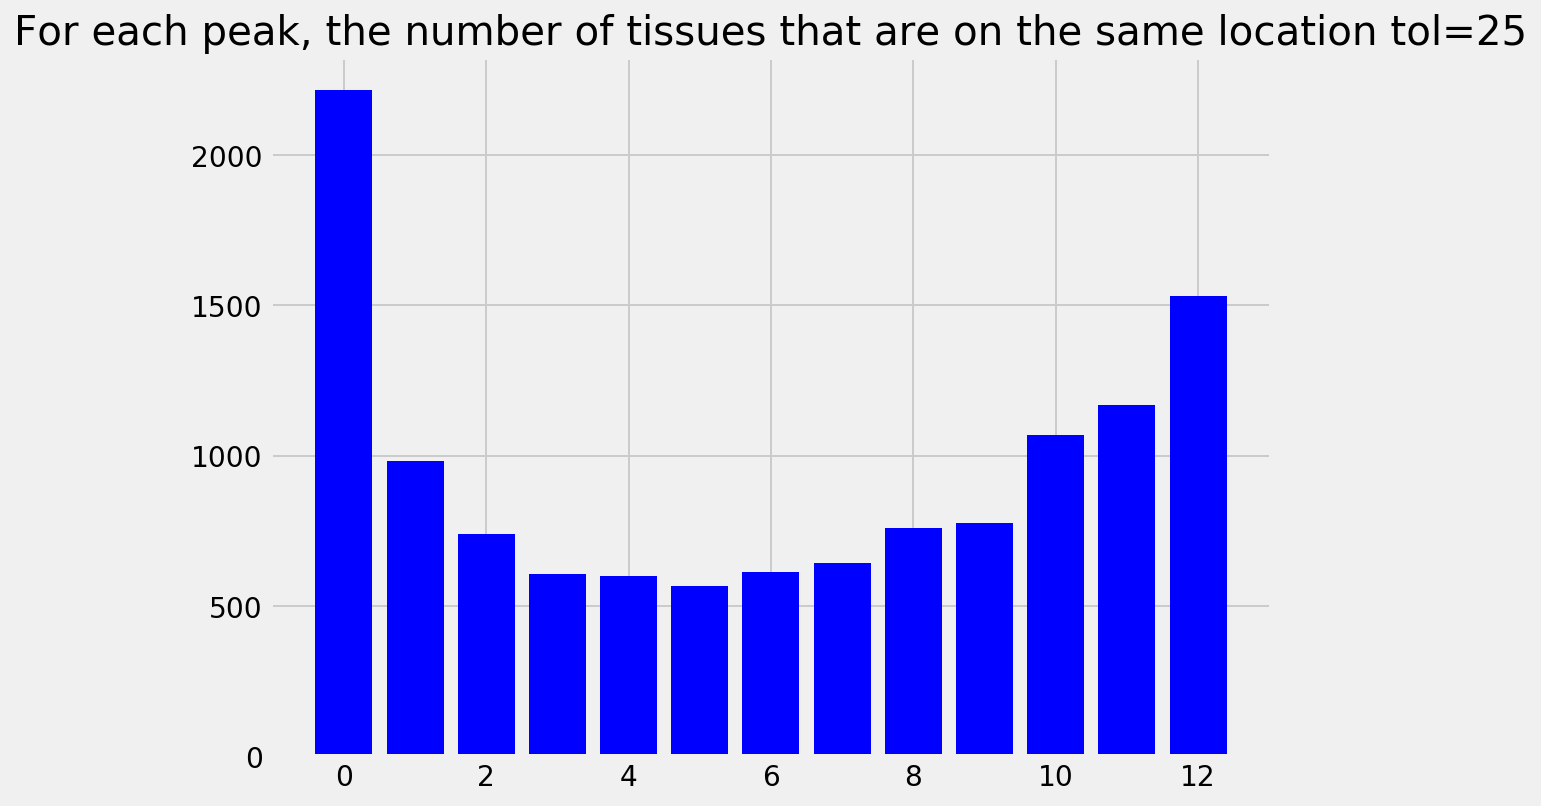

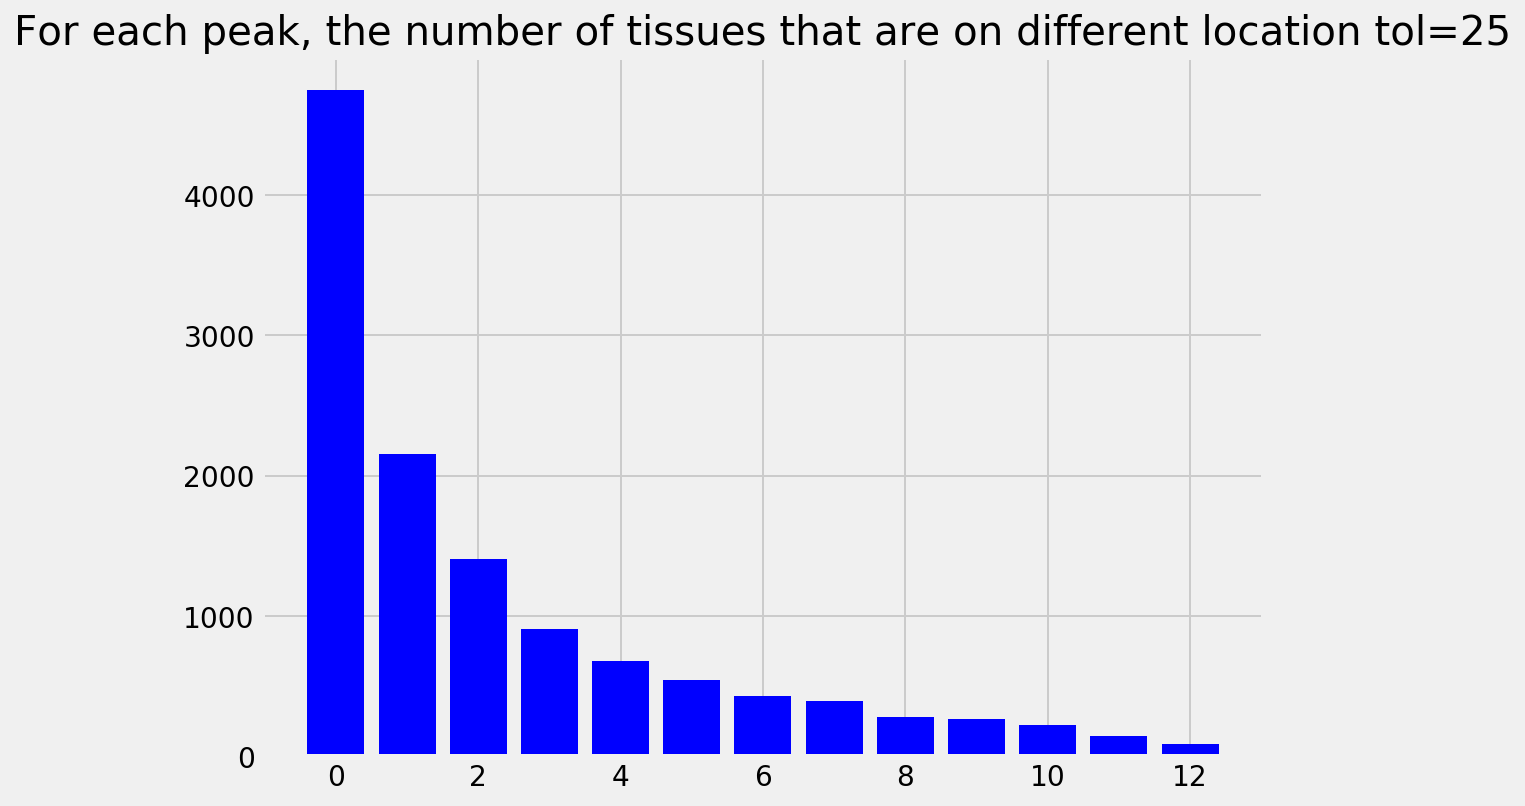

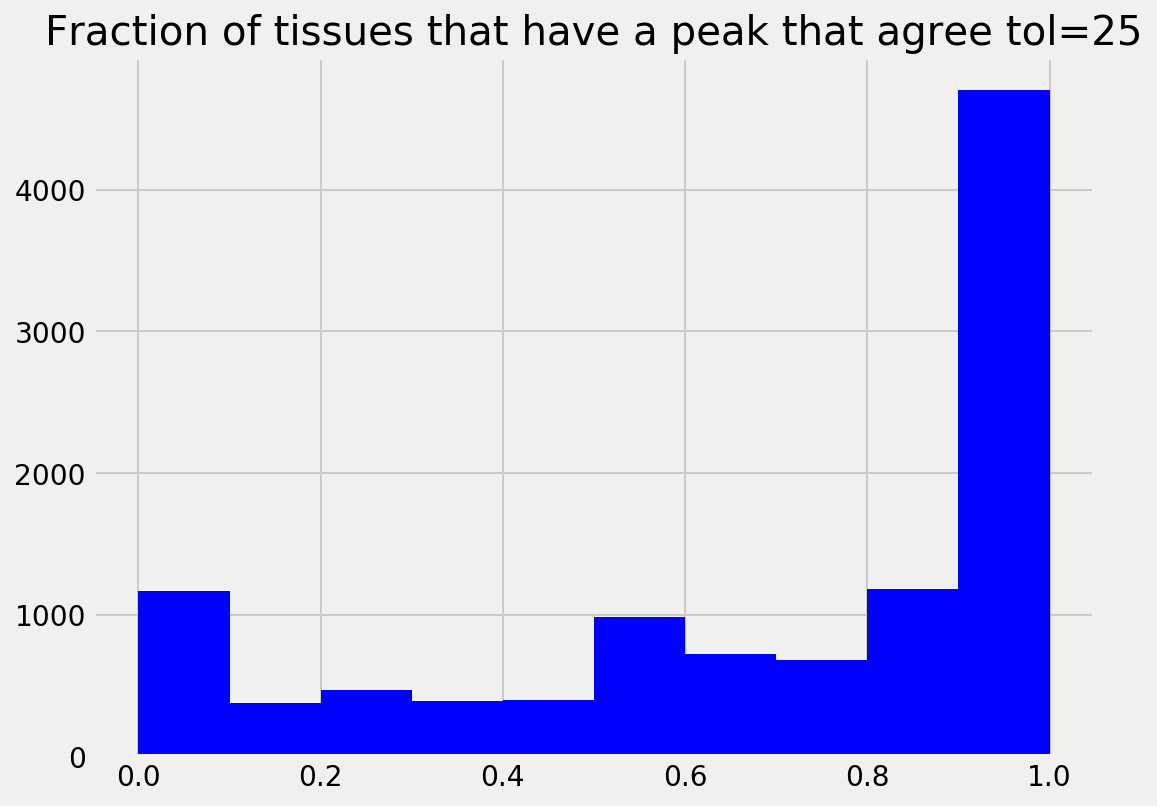

In [27]:
peaks_cho_agree, peaks_cho_disagree = agree_peaks(tissue_peaks_by_location,tol=25, tissue='CHO')
f = plt.figure()
labels, values = zip(*Counter(peaks_cho_agree.values()).items())
plt.bar(labels, values)
plt.title("For each peak, the number of tissues that are on the same location tol=25")
#pd.Series(Counter(peaks_cho_agree)).plot.bar(color='y')


f = plt.figure()
labels, values = zip(*Counter(peaks_cho_disagree.values()).items())
plt.bar(labels, values)
plt.title("For each peak, the number of tissues that are on different location tol=25")


fraction_agree = []
for p in peaks_cho_agree:
    num_tot = peaks_cho_agree[p]+peaks_cho_disagree[p]
    if not num_tot == 0:
        fraction_agree.append(peaks_cho_agree[p]/(peaks_cho_agree[p]+peaks_cho_disagree[p]))

f = plt.figure()
plt.hist(fraction_agree)
plt.title("Fraction of tissues that have a peak that agree tol=25")

### A. TSS only in CHO

In [28]:
only_in_cho = retrieve_peaks(tissue_peaks_by_location, meta_df, peaks_cho_agree, peaks_cho_disagree, n_ag=20, n_dis=20,n_tot=0)
only_in_cho

,Tissues,cs,CHO ATAC Region,ID,Gene,Gene ID,Transcript,Is Experimental
p2@Dlgap5_XM_027386546.1,"BMDMwt,Brain,MiscOrgans,Spleen,CHO,BMDM1hKLA,F...",0b10,NaN,108479,Dlgap5,NaN,XM_027386546.1,1.0
p1@LOC100768260_XM_027386564.1,CHO,0b00,NaN,344845,LOC100768260,NaN,XM_027386564.1,1.0
p2@Chd8_XM_027386661.1,"Heart,Spleen,MiscOrgans,FemaleReproductive,CHO...",0b00,NaN,352245,Chd8,NaN,XM_027386661.1,1.0
p1@Il1rl1_XM_027386751.1,CHO,0b10,NaN,490977,Il1rl1,NaN,XM_027386751.1,1.0
p2@Map4k4_XM_027386764.1,"Heart,Spleen,MiscOrgans,FemaleReproductive,CHO...",0b10,NaN,104084,Map4k4,NaN,XM_027386764.1,1.0
...,...,...,...,...,...,...,...,...
p2@LOC113838138_XM_027433907.1,"BMDMwt,Spleen,FemaleReproductive,CHO,Brain,Lun...",0b00,NaN,102866,LOC113838138,NaN,XM_027433907.1,1.0
p1@LOC107977324_XM_027434064.1,CHO,0b10,NaN,103618,LOC107977324,NaN,XM_027434064.1,1.0
p2@LOC107977324_XM_027434064.1,CHO,0b00,NaN,419522,LOC107977324,NaN,XM_027434064.1,1.0
p1@LOC100757478_XM_027434222.1,CHO,0b00,NaN,288708,LOC100757478,NaN,XM_027434222.1,1.0


### B. TSS offset  CHO and other tissues

In [29]:
cho_dis3 = retrieve_peaks(tissue_peaks_by_location, meta_df, peaks_cho_agree, peaks_cho_disagree, n_ag=0, n_dis=3,n_tot=-1)
cho_dis3

,Tissues,cs,CHO ATAC Region,ID,Gene,Gene ID,Transcript,Is Experimental
p1@Cdkn3_XM_027386531.1,"BMDMwt,Spleen,MiscOrgans,FemaleReproductive,CH...",0b11,NaN,237253,Cdkn3,NaN,XM_027386531.1,1.0
p1@Cgrrf1_XM_027386536.1,"Heart,Spleen,MiscOrgans,FemaleReproductive,CHO...",0b11,NaN,348288,Cgrrf1,NaN,XM_027386536.1,1.0
p1@Socs4_XM_027386543.1,"Heart,Spleen,MiscOrgans,FemaleReproductive,CHO...",0b11,NaN,160861,Socs4,NaN,XM_027386543.1,1.0
p1@Naa30_XM_027386575.1,"BMDMwt,MiscOrgans,FemaleReproductive,CHO,Brain...",0b10,NaN,11637,Naa30,NaN,XM_027386575.1,1.0
p2@Naa30_XM_027386575.1,"BMDMwt,MiscOrgans,FemaleReproductive,CHO,Brain...",0b10,NaN,179,Naa30,NaN,XM_027386575.1,1.0
...,...,...,...,...,...,...,...,...
p1@LOC100765869_XM_027434018.1,"Heart,Spleen,MiscOrgans,FemaleReproductive,CHO...",0b11,NaN,487141,LOC100765869,NaN,XM_027434018.1,1.0
p1@LOC113838273_XM_027434054.1,"Heart,Spleen,MiscOrgans,FemaleReproductive,CHO...",0b11,NaN,130209,LOC113838273,NaN,XM_027434054.1,1.0
p1@LOC113838538_XM_027434165.1,"MiscOrgans,CHO,Brain,Lung,Muscle,Kidney",0b00,NaN,22579,LOC113838538,NaN,XM_027434165.1,1.0
p1@LOC113838537_XM_027434161.1,"Heart,Spleen,FemaleReproductive,CHO,Brain,Lung...",0b11,NaN,508225,LOC113838537,NaN,XM_027434161.1,1.0


### C. TSS agree CHO and tissues

In [30]:
cho_ag3 = retrieve_peaks(tissue_peaks_by_location, meta_df, peaks_cho_agree, peaks_cho_disagree, n_ag=3, n_dis=0,n_tot=-1)
cho_ag3

,Tissues,cs,CHO ATAC Region,ID,Gene,Gene ID,Transcript,Is Experimental
p1@Cdkn3_XM_027386531.1,"BMDMwt,Spleen,MiscOrgans,FemaleReproductive,CH...",0b11,NaN,237253,Cdkn3,NaN,XM_027386531.1,1.0
p1@Cnih1_XM_027386534.1,"Heart,BMDMwt,Spleen,MiscOrgans,FemaleReproduct...",0b11,NaN,298307,Cnih1,NaN,XM_027386534.1,1.0
p1@Cgrrf1_XM_027386536.1,"Heart,Spleen,MiscOrgans,FemaleReproductive,CHO...",0b11,NaN,348288,Cgrrf1,NaN,XM_027386536.1,1.0
p1@Samd4a_XM_027386537.1,"Heart,Spleen,MiscOrgans,FemaleReproductive,Bra...",0b11,NaN,342596,Samd4a,NaN,XM_027386537.1,1.0
p1@Gch1_XM_027386540.1,"Heart,BMDMwt,Spleen,MiscOrgans,FemaleReproduct...",0b11,NaN,243948,Gch1,NaN,XM_027386540.1,1.0
...,...,...,...,...,...,...,...,...
p1@Twistnb_XM_027434130.1,"Heart,Spleen,MiscOrgans,FemaleReproductive,CHO...",0b11,NaN,162952,Twistnb,NaN,XM_027434130.1,1.0
p1@LOC113838541_XM_027434168.1,"Heart,Spleen,MiscOrgans,FemaleReproductive,CHO...",0b11,NaN,145836,LOC113838541,NaN,XM_027434168.1,1.0
p1@LOC113838537_XM_027434161.1,"Heart,Spleen,FemaleReproductive,CHO,Brain,Lung...",0b11,NaN,508225,LOC113838537,NaN,XM_027434161.1,1.0
p1@LOC113839076_XM_027434536.1,"Heart,BMDMwt,MiscOrgans,Spleen,FemaleReproduct...",0b11,NaN,23577,LOC113839076,NaN,XM_027434536.1,1.0


### D. TSS different across CHO samples

### E. Location is the maximum difference one

In [31]:
cho_dis3_maxDist_bed = bed_df.loc[cho_dis3.index]

for p in tqdm(cho_dis3["ID"].values):
    cho = tissue_peaks_by_location.loc[p, tissue]
    new_start = int(tissue_peaks_by_location.loc[p,(np.abs(cho - tissue_peaks_by_location.loc[p])).idxmax()])
    if new_start != 0:
        tss_index = meta_df[meta_df["ID"] == p].index[0]
        cho_dis3_maxDist_bed.loc[tss_index, "Start"] = new_start-76
        cho_dis3_maxDist_bed.loc[tss_index, "End"] = new_start+75



100%|██████████| 3972/3972 [00:21<00:00, 186.02it/s]


#### Save results as bed files

In [32]:
write_bed_file(cho_dis3_maxDist_bed, os.path.join(save_dir,"cho_disagree3_maxDistance_tol_25.tsv" ))
write_bed_file(bed_df.loc[cho_ag3.index], os.path.join(save_dir, "cho_agree3_tol_25.tsv"))
write_bed_file(bed_df.loc[cho_dis3.index], os.path.join(save_dir, "cho_disagree3_tol_25.tsv"))
write_bed_file(bed_df.loc[only_in_cho.index], os.path.join(save_dir, "cho_only_tol_25.tsv"))